In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import matplotlib.pyplot as plt
import os
import re
import rasterio as rio
from rasterio.mask import mask
import rasterio.plot
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, denoise_nl_means
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from src.denoising import denoise_swt, apply_wavelet, apply_tv, apply_nlm, apply_bil
from src.ecs import ECS
from src.segmentation import segment2d, segment_metrics
from src.preproc import save_with_rio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

cmap = mcolors.LinearSegmentedColormap.from_list('red_green', ['red', 'green'])

plt.rcParams.update({'font.size': 16})

In [2]:
def load_all_startswith(directory, starts_with):
    files = [directory + "/" + f for f in os.listdir(directory) 
             if os.path.isfile(os.path.join(directory, f)) and f.startswith(starts_with)]
    def extract_number(s):
        match = re.search(r'\d+', s)
        return int(match.group()) if match else float('inf')
    
    sorted_files = sorted(files, key=extract_number)

    X = []
    for i in sorted_files:
        temp = rio.open(i)
        X.append(temp.read())
        temp.close()
    X = np.concatenate(X)

    return X

In [3]:
scaled = load_all_startswith('data/scaled/', 'scaled')

In [4]:
scaled = scaled[:,:-1,:]

In [5]:
scaled.shape

(93, 350, 600)

In [6]:
def add_noise(img, std_dev=1, avg=0):
    noise = np.random.normal(avg, std_dev, img.shape)
    noised = np.add(img, noise)
    return noised

In [22]:
original = scaled[0]
noisy_wav = denoise_swt(original)
noisy_tv = denoise_tv_chambolle(original, weight=0.1)
noisy_bil = denoise_bilateral(original)
noisy_nlm = denoise_nl_means(original)

In [11]:
def rectangle_off_center(arr, rect_height, rect_width, mode='mask'):
    """
    Extracts or masks a centered rectangle in a 2D NumPy array.

    Parameters:
        arr (np.ndarray): 2D input array.
        rect_height (int): Height of the rectangle.
        rect_width (int): Width of the rectangle.
        mode (str): 'mask' to set the rectangle to 0 in the original array,
                    'extract' to return the rectangular region only.

    Returns:
        np.ndarray: Modified array (if mask) or extracted region (if extract).
    """
    if arr.ndim != 2:
        raise ValueError("Input array must be 2D.")

    center_y, center_x = arr.shape[0] // 2, arr.shape[1] // 2
    y1 = max(0, center_y - rect_height // 2)
    y2 = min(arr.shape[0], center_y + rect_height // 2)
    x1 = max(0, center_x - rect_width // 2)
    x2 = min(arr.shape[1], center_x + rect_width // 2)

    if mode == 'extract':
        return arr[y1:y2, x1:x2]
    elif mode == 'mask':
        arr_copy = arr.copy()
        arr_copy[y1:y2, x1:x2] = 0
        return arr_copy
    else:
        raise ValueError("Mode must be 'mask' or 'extract'")

In [32]:
rec_height = 200 
rec_width = 200

original = rectangle_off_center(original, rec_height, rec_width, 'extract') 
noisy_wav = rectangle_off_center(noisy_wav, rec_height, rec_width, 'extract')
noisy_tv = rectangle_off_center(noisy_tv, rec_height, rec_width, 'extract')  
noisy_bil = rectangle_off_center(noisy_bil, rec_height, rec_width, 'extract')
noisy_nlm = rectangle_off_center(noisy_nlm, rec_height, rec_width, 'extract')

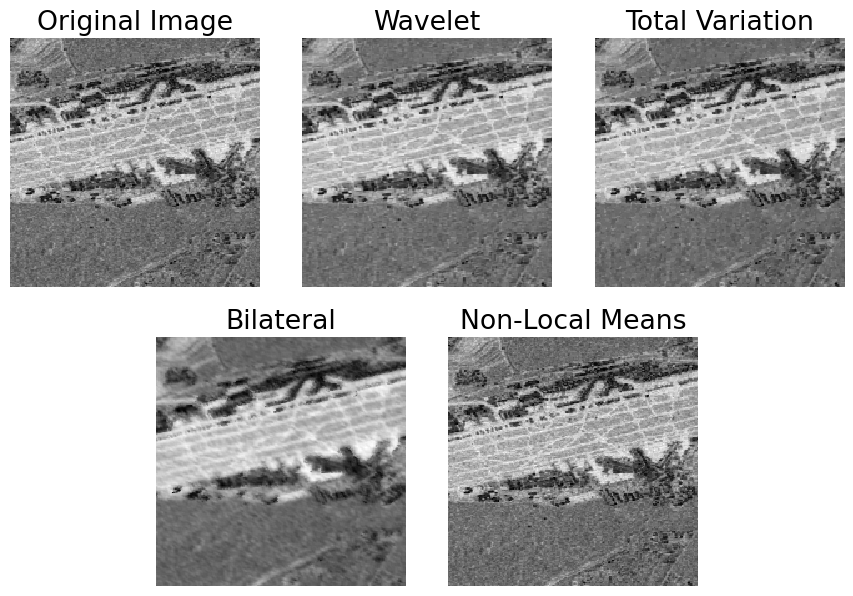

In [209]:
fig = plt.figure(figsize=(11, 11))
ax1 = plt.subplot2grid((3,6), (0,0), colspan=2, fig=fig)
ax2 = plt.subplot2grid((3,6), (0,2), colspan=2, fig=fig)
ax3 = plt.subplot2grid((3,6), (0,4), colspan=2, fig=fig)
ax4 = plt.subplot2grid((3,6), (1,1), colspan=2, fig=fig)
ax5 = plt.subplot2grid((3,6), (1,3), colspan=2, fig=fig)

palette = 'gray'

ax1.imshow(original, interpolation='nearest', cmap=palette)
ax1.set_axis_off()
ax1.set_title('Original Image')

ax2.imshow(noisy_wav, interpolation='nearest', cmap=palette)
ax2.set_axis_off()
ax2.set_title('Wavelet')

ax3.imshow(noisy_tv, interpolation='nearest', cmap=palette)
ax3.set_axis_off()
ax3.set_title('Total Variation')

ax4.imshow(noisy_bil, interpolation='nearest', cmap=palette)
ax4.set_axis_off()
ax4.set_title('Bilateral')

ax5.imshow(noisy_nlm, interpolation='nearest', cmap=palette)
ax5.set_axis_off()
ax5.set_title('Non-Local Means')

plt.savefig('results/smoothing-methods.png', dpi=300, bbox_inches='tight')

In [34]:
ssim_wav = structural_similarity(original, noisy_wav, data_range=noisy_wav.max() - noisy_wav.min())
ssim_tv = structural_similarity(original, noisy_tv, data_range=noisy_tv.max() - noisy_tv.min())
ssim_bil = structural_similarity(original, noisy_bil, data_range=noisy_bil.max() - noisy_bil.min())
ssim_nlm = structural_similarity(original, noisy_nlm, data_range=noisy_nlm.max() - noisy_nlm.min())

print('SSim Wavelet: ', str(ssim_wav), '\nSSim TV: ', str(ssim_tv), '\nSSim Bilateral: ', str(ssim_bil), '\nSSim Non-Local Means: ', str(ssim_nlm))

SSim Wavelet:  0.9468612846703083 
SSim TV:  0.9510413854415234 
SSim Bilateral:  0.27260676126727323 
SSim Non-Local Means:  0.9999997550506355


In [35]:
denoised_wav = apply_wavelet(scaled)
print('\n')
denoised_tv = apply_tv(scaled, w=0.1)
print('\n')
denoised_nlm = apply_nlm(scaled)
print('\n')
denoised_bil = apply_bil(scaled)

Applying Wavelet:  93 / 93

Applying TV:  93 / 93

Applying NLM:  93 / 93



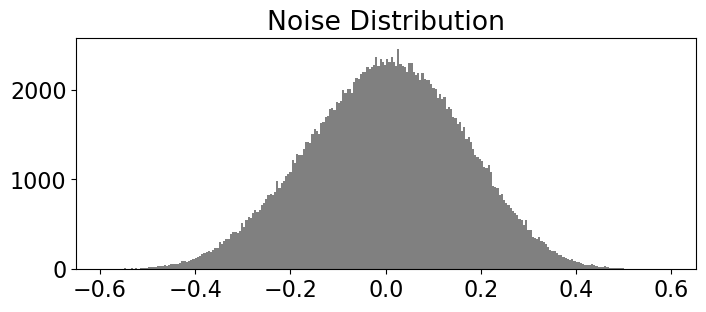

In [36]:
mean_scaled = scaled[0]
mean_smooth = denoised_wav[0]

noise = mean_smooth - mean_scaled

plt.figure(figsize=(8,3))
plt.title('Noise Distribution')
plt.hist(noise.flatten(), 256, color='gray')
plt.savefig('results/noise-distribution.png', dpi=300, bbox_inches='tight')

In [37]:
ecs_wav = ECS(scaled, smooth_img=denoised_wav)
ecs_tv = ECS(scaled, smooth_img=denoised_tv)
ecs_nlm = ECS(scaled, smooth_img=denoised_nlm)
ecs_bil = ECS(scaled, smooth_img=denoised_bil)

In [38]:
ecs_wav_seg = segment2d(ecs_wav, method='ot')
ecs_tv_seg = segment2d(ecs_tv, method='ot')
ecs_nlm_seg = segment2d(ecs_nlm, method='ot')
ecs_bil_seg = segment2d(ecs_bil, method='ot')

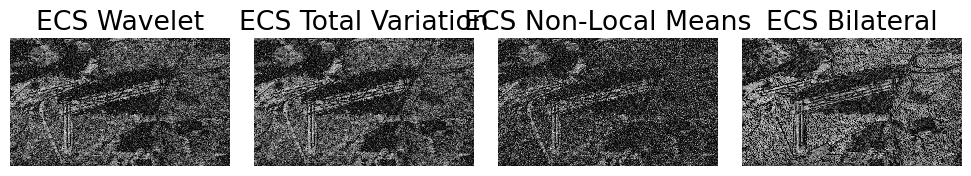

In [39]:
fig, axes = plt.subplots(1, 4, figsize=(10, 13))

palette = 'gray'

axes[0].imshow(ecs_wav, interpolation='nearest', cmap=palette)
axes[0].set_title('ECS Wavelet')
axes[0].set_axis_off()

axes[1].imshow(ecs_tv, interpolation='nearest', cmap=palette)
axes[1].set_title('ECS Total Variation')
axes[1].set_axis_off()

axes[2].imshow(ecs_nlm, interpolation='nearest', cmap=palette)
axes[2].set_title('ECS Non-Local Means')
axes[2].set_axis_off()

axes[3].imshow(ecs_bil, interpolation='nearest', cmap=palette)
axes[3].set_title('ECS Bilateral')
axes[3].set_axis_off()

plt.tight_layout()
plt.show()

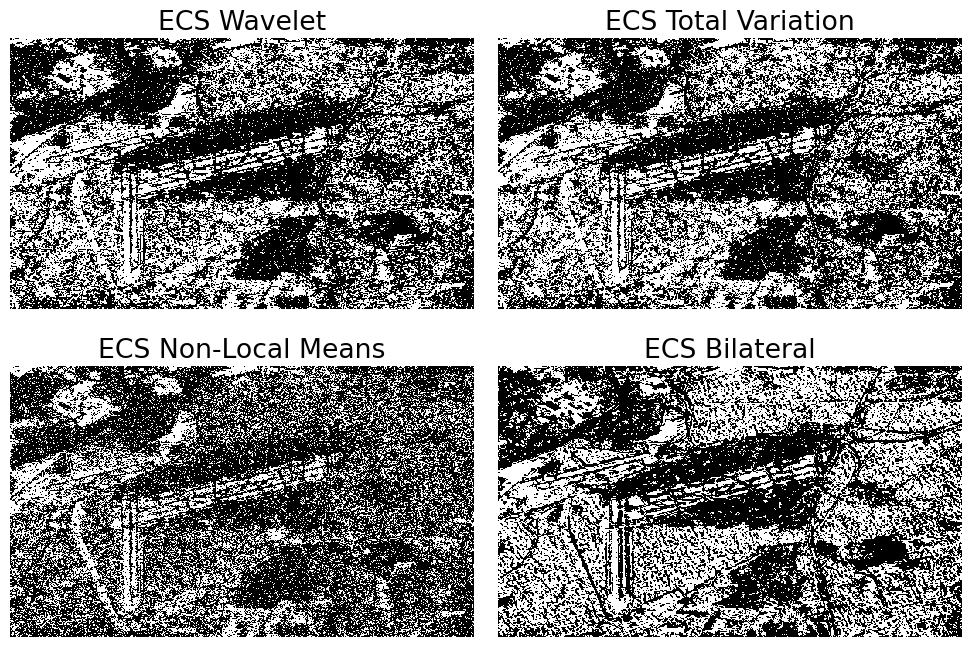

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

palette = 'gray'

axes[0, 0].imshow(ecs_wav_seg, interpolation='nearest', cmap=palette)
axes[0, 0].set_title('ECS Wavelet')
axes[0, 0].set_axis_off()

axes[0, 1].imshow(ecs_tv_seg, interpolation='nearest', cmap=palette)
axes[0, 1].set_title('ECS Total Variation')
axes[0, 1].set_axis_off()

axes[1, 0].imshow(ecs_nlm_seg, interpolation='nearest', cmap=palette)
axes[1, 0].set_title('ECS Non-Local Means')
axes[1, 0].set_axis_off()

axes[1, 1].imshow(ecs_bil_seg, interpolation='nearest', cmap=palette)
axes[1, 1].set_title('ECS Bilateral')
axes[1, 1].set_axis_off()

plt.tight_layout()
plt.savefig('results/all-ecs-tests.png', dpi=600, bbox_inches='tight')

In [6]:
temp = rio.open('data/scaled/scaled_0.tif')
temp.close()

In [7]:
changes = gpd.read_file('data/shp/changes.shp')
nonchanges = gpd.read_file('data/shp/nonchanges.shp')

In [8]:
changes['name'] = 'Changes'
nonchanges['name'] = 'Non-Changes'
gdf = gpd.GeoDataFrame(pd.concat([changes, nonchanges], ignore_index=True))

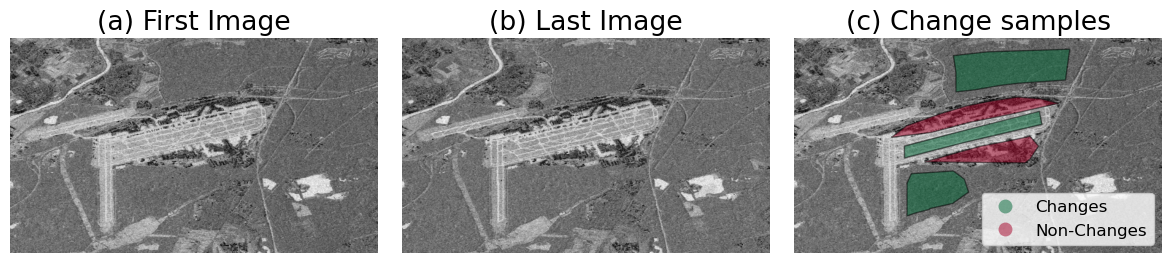

In [9]:
fig, (axs1, axs2, axs3) = plt.subplots(1, 3, figsize=(12, 7))

temp = rio.open('data/scaled/scaled_0.tif')
bounds = temp.bounds

# First image (axs1)
axs1.imshow(scaled[0], cmap='gray')
axs1.set_title('(a) First Image')
axs1.set_axis_off()

# Second image (axs2)
axs2.imshow(scaled[80], cmap='gray')
axs2.set_title('(b) Last Image')
axs2.set_axis_off()

# Third image (axs3)
rio.plot.show(temp, ax=axs3, cmap='gray')
gdf.plot(ax=axs3, column='name', legend=True, alpha=0.5, edgecolor='k', cmap='RdYlGn_r', legend_kwds={'fontsize': 12, 'loc':'lower right'})
axs3.set_title('(c) Change samples')
axs3.set_axis_off()

axs3.set_xlim(bounds[0], bounds[2])
axs3.set_ylim(bounds[1], bounds[3])

# Make sure all axes have the same aspect ratio
axs1.set_aspect('equal')
axs2.set_aspect('equal')
axs3.set_aspect('equal')

# Show the plot
plt.tight_layout()
plt.savefig('results/change-samples.png', dpi=300, bbox_inches='tight')

In [16]:
# Cropped images
change_crop, change_crop_transform = mask(temp, gdf.geometry, crop=True, nodata=9999)

dst_kwargs = temp.meta
dst_kwargs.update({
    'nodata': 9999,
    'transform': change_crop_transform,
    'width': change_crop.shape[2],
    'height': change_crop.shape[1]
})
new_dataset = rasterio.open(
    'results/cropped.tif', 
    'w', 
    **dst_kwargs
)
new_dataset.write(change_crop)
new_dataset.close()

CPLE_AppDefinedError: Deleting results/cropped.tif failed: Permission denied

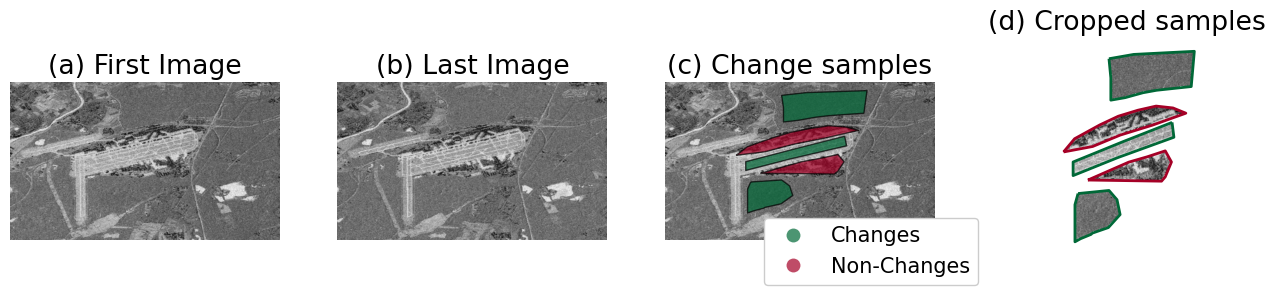

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(13, 11))

temp = rio.open('data/scaled/scaled_0.tif')
cutout = rio.open('results/cropped.tif')
bounds = temp.bounds

# First image (axs1)
axs[0].imshow(scaled[0], cmap='gray')
axs[0].set_title('(a) First Image')
axs[0].set_axis_off()

# Second image (axs2)
axs[1].imshow(scaled[80], cmap='gray')
axs[1].set_title('(b) Last Image')
axs[1].set_axis_off()

# Third image (axs3)
rio.plot.show(temp, ax=axs[2], cmap='gray')
gdf.plot(
    ax=axs[2], 
    column='name',
    legend=True, 
    alpha=0.7, 
    edgecolor='k',
    cmap='RdYlGn_r', 
    legend_kwds={'fontsize': 15, 'loc':'lower right'})
axs[2].set_title('(c) Change samples')
axs[2].set_axis_off()
axs[2].get_legend().set_bbox_to_anchor((1.2, -0.35))
axs[2].get_legend().get_frame().set_alpha(None)
axs[2].set_xlim(bounds[0], bounds[2])
axs[2].set_ylim(bounds[1], bounds[3])

# Fourth image
rio.plot.show(cutout, ax=axs[3], cmap='gray')
gdf.plot(
    ax=axs[3], 
    column='name',
    facecolor='none', 
    cmap='RdYlGn_r',
    linewidth=2)
axs[3].set_title('(d) Cropped samples')
axs[3].set_axis_off()
axs[3].set_xlim(bounds[0], bounds[2])
axs[3].set_ylim(bounds[1], bounds[3])

# Make sure all axes have the same aspect ratio
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
axs[2].set_aspect('equal')

# Show the plot
plt.tight_layout()
plt.savefig('results/change-samples.png', dpi=300, bbox_inches='tight')

In [20]:
save_with_rio('results/ecs_wav.tif', ecs_wav_seg, temp)
save_with_rio('results/ecs_tv.tif', ecs_tv_seg, temp)
save_with_rio('results/ecs_nlm.tif', ecs_nlm_seg, temp)
save_with_rio('results/ecs_bil.tif', ecs_bil_seg, temp)

True

In [21]:
ecs_wav_metrics, _, _ = segment_metrics('results/ecs_wav.tif', 'data/shp/changes.shp', 'data/shp/nonchanges.shp')
ecs_tv_metrics, _, _ = segment_metrics('results/ecs_tv.tif', 'data/shp/changes.shp', 'data/shp/nonchanges.shp')
ecs_nlm_metrics, _, _ = segment_metrics('results/ecs_nlm.tif', 'data/shp/changes.shp', 'data/shp/nonchanges.shp')
ecs_bil_metrics, _, _ = segment_metrics('results/ecs_bil.tif', 'data/shp/changes.shp', 'data/shp/nonchanges.shp')

In [22]:
changes.to_file('changes.geojson', driver='GeoJSON')

In [23]:
ecs_wav_metrics['model'] = 'Wavelet'
ecs_tv_metrics['model'] = 'Total Variation'
ecs_nlm_metrics['model'] = 'Non-Local Means'
ecs_bil_metrics['model'] = 'Bilateral'

metrics = pd.DataFrame([ecs_wav_metrics, ecs_tv_metrics, ecs_nlm_metrics, ecs_bil_metrics])
metrics

,f1,precision,recall,accuracy,model
0,0.685914,0.940861,0.539677,0.671949,Wavelet
1,0.697364,0.942253,0.553508,0.681130,Total Variation
2,0.532775,0.847314,0.388541,0.547678,Non-Local Means
3,0.741957,0.938388,0.613529,0.716746,Bilateral


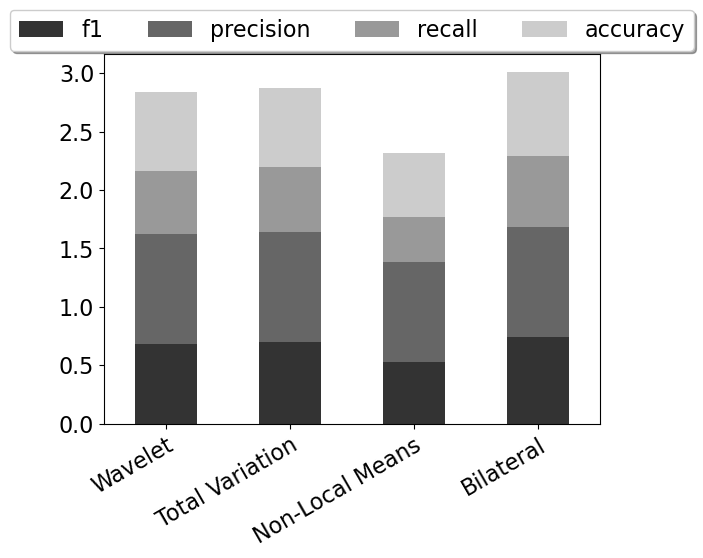

In [24]:
ax = metrics.plot(
    x='model',
    kind='bar',
    stacked=True,
    xlabel='',
    color = ['0.2', '0.4', '0.6', '0.8']
)
ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)
plt.xticks(rotation=30, ha='right', rotation_mode='anchor')
plt.savefig('results/metric-bars.png', dpi=300, bbox_inches='tight')